# M1. Actividad

Presenta: David René Lagarica Hernández | A01708936
<!-- new line -->
12 de noviembre de 2023

## Problema

Se necesita desarrollar una simulación de robots de limpieza reactivos en un entorno controlado. El entorno es una habitación bidimensional, donde un número definido de agentes de limpieza operan bajo un conjunto de reglas establecidas. 
<!--  -->
Al iniciar la simulación, un porcentaje de las celdas de la habitación están sucias y distribuidas aleatoriamente. Los agentes comienzan desde la celda [1,1] y en cada unidad de tiempo, deben decidir si limpiar la celda actual si está sucia, o moverse aleatoriamente a una de las celdas adyacentes si está limpia. El movimiento está restringido a las celdas vecinas, y si un movimiento deseado es imposible, el agente permanece estático. 
<!--  -->
La simulación debe ejecutarse hasta alcanzar un límite de tiempo predefinido. Se deben considerar dos escenarios de prueba: el primero con un solo agente y el segundo con dos agentes. En ambos casos, el tamaño de la habitación debe ser de 100x100 celdas y 90% de esas celdas se encuentran sucias.

## Solución

In [8]:
from mesa import Agent, Model 
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import matplotlib.pyplot as plt
import numpy as np

In [9]:
class VacuumAgent(Agent):
    """
    Constructor for VacuumAgent class.
    
    Args:
        unique_id: Unique identifier for the agent.
        model: Reference to the model in which the agent is instantiated.
    """
    def __init__(self, id, model):
        super().__init__(id, model)

    """
    The move method is called by the scheduler in order to move the agent.
    The agent will move to a random cell in its neighborhood.
    """
    def move(self):
        neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        dirtyCells = [cell for cell in neighborhood if self.model.isDirty(cell)]
        validPositions = [position for position in neighborhood if self.model.grid.is_cell_empty(position) or position in dirtyCells]

        if validPositions:
            newPosition = self.random.choice(validPositions)
            self.model.grid.move_agent(self, newPosition)
        else:
            pass

    """
    The clean method is called by the scheduler in order to clean the cell
    in which the agent is located if it is dirty
    """
    def clean(self):
        if self.model.isDirty(self.pos):
            self.model.cleanCell(self.pos)
    
    """
    The step method is called by the scheduler in order to execute the
    agent's actions.
    """
    def step(self):
        self.clean()
        self.move()

In [10]:
"""
The getGrid function is used to get the grid of the model for plotting.

Returns:
    grid: A matrix with the same dimensions as the model's grid. Each cell
          contains a 1 if it is dirty and a 0 if it is clean.
"""
def getGrid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for (content, (x, y)) in model.grid.coord_iter():
        if model.isDirty((x, y)):
            grid[x][y] = 1 
        else:
            grid[x][y] = 0
    return grid

"""
The calculate_dirtiness function is used to calculate the total dirtiness

Returns:
    dirtiness: The total dirtiness of the model's grid.
"""
def calculate_dirtiness(model):
        return np.sum(model.dirt)

In [11]:
class VacuumModel(Model):
    """
    Constructor for VacuumModel class.

    Args:
        width: Width of the grid.
        height: Height of the grid.
        dirtiness: Percentage of cells that will be dirty at the beginning of the simulation.
        nAgents: Number of agents in the simulation.
    """
    def __init__(self, width, height, dirtiness, nAgents, dataCollectorActivated):
        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.dirt = np.random.binomial(1, dirtiness, (width, height)).astype(bool)
        self.dataCollector = DataCollector(model_reporters={'Grid': getGrid}) if dataCollectorActivated else None
        self.dirtDataCollector = DataCollector(
            {"Dirtiness": calculate_dirtiness})

        for i in range (nAgents):
            agent = VacuumAgent(i, self)
            self.schedule.add(agent)
            self.grid.place_agent(agent, (1,1))
            
    """
    The isDirty method is used to check if a cell is dirty.
    
    Returns:
        True if the cell is dirty, False otherwise.
    """
    def isDirty(self, pos):
        return self.dirt[pos[0], pos[1]]
    
    """
    The cleanCell method is used to clean a cell.
    """
    def cleanCell(self, pos):
        self.dirt[pos[0], pos[1]] = False
        
    """
    The step method is called by the scheduler in order to execute the
    model's actions.
    """
    def step(self):
        self.schedule.step()
        self.dirtDataCollector.collect(self)
        
        if self.dataCollector is not None:
            self.dataCollector.collect(self)


In [12]:
WIDTH = 100
HEIGHT = 100
DIRTINESS = 0.9
N_AGENTS = 1
MAX_GENERATIONS = 100
DATA_COLLECTOR_ACTIVATED = True

model = VacuumModel(WIDTH, HEIGHT, DIRTINESS, N_AGENTS, DATA_COLLECTOR_ACTIVATED)

for _ in range(MAX_GENERATIONS):
    if np.sum(model.dirt) == 0:
        break
    model.step()
    
percentage = (calculate_dirtiness(model) / (WIDTH * HEIGHT)) * 100

print(f'Pasos totales: {model.schedule.steps}')
print(f'Porcentaje de celdas sucias: {round(percentage, 2)}%')

Pasos totales: 100
Porcentaje de celdas sucias: 89.53%


c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


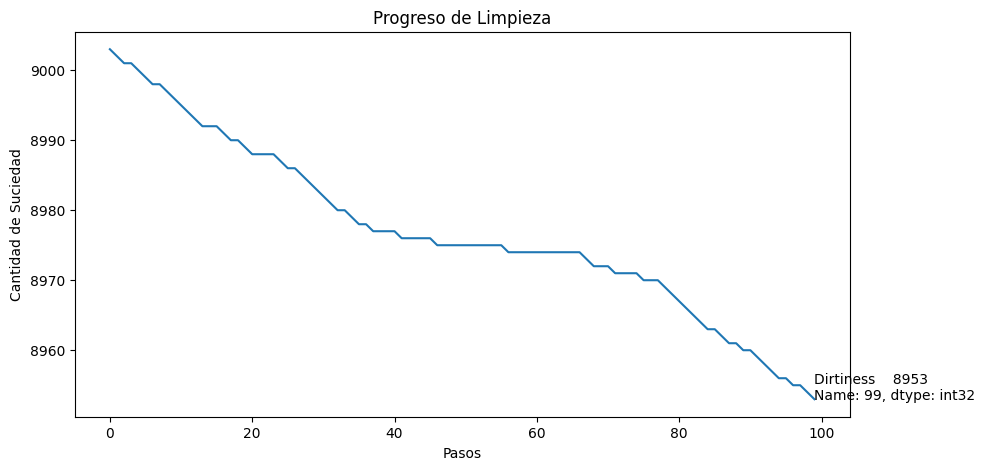

In [13]:
allDirtiness = model.dirtDataCollector.get_model_vars_dataframe()
plt.figure(figsize=(10, 5))
plt.plot(allDirtiness)
plt.xlabel('Pasos')
plt.ylabel('Cantidad de Suciedad')
plt.title('Progreso de Limpieza')
plt.text(allDirtiness.index[-1], allDirtiness.iloc[-1], str(allDirtiness.iloc[-1]))
plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_24208\1989240777.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.imshow(allGrid.iloc[-1][0], cmap=plt.cm.binary)


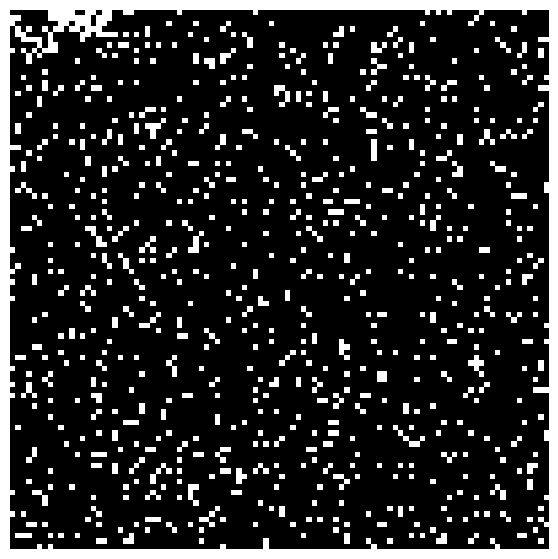

In [14]:
if DATA_COLLECTOR_ACTIVATED:
    allGrid = model.dataCollector.get_model_vars_dataframe()
    plt.figure(figsize=(7, 7))
    plt.imshow(allGrid.iloc[-1][0], cmap=plt.cm.binary)
    plt.axis('off')
    plt.show()